# E-Commerce Data Science Portfolio

# Analysis of Customer Purchase Behaviour

### Step 1: Get all the Tools Ready.

In [45]:
import pandas as pd # laoading and manipulating data
import numpy as np # maths operations
import matplotlib.pyplot as plt # for charts
import seaborn as sns # styling

from sklearn.cluster import KMeans # kmeans clustering
from sklearn.preprocessing import StandardScaler #scaler -> no overpowering

### Step 2: Load and merge the data together

In [46]:
# Load the data
customers = pd.read_csv("../data/olist_customers_dataset.csv")
orders = pd.read_csv("../data/olist_orders_dataset.csv") 
order_items = pd.read_csv("../data/olist_order_items_dataset.csv")
products = pd.read_csv("../data/olist_products_dataset.csv")

# Merge the data together
customer_orders = pd.merge(orders, customers, on='customer_id')
all_data = pd.merge(customer_orders, order_items, on='order_id')
all_data = pd.merge(all_data, products, on='product_id')

# Customer stats
customer_stats = all_data.groupby('customer_id').agg({
    'price': 'sum',
    'product_id': 'nunique',
    'product_category_name': 'nunique'
}).reset_index()

customer_stats.columns = ['customer_id', 'total_spent', 'items_bought', 'categories_tried']

# Show the details of the merged data
print(f"\nTotal customers: {len(customer_stats)}")
print(f"Average spent per customer: R$ {customer_stats['total_spent'].mean():.2f}")
print(f"Average items per customer: {customer_stats['items_bought'].mean():.1f}")
print(f"Average categories per customer: {customer_stats['categories_tried'].mean():.1f}\n")


Total customers: 98666
Average spent per customer: R$ 137.75
Average items per customer: 1.0
Average categories per customer: 1.0



### Step 3: Grouping by spending levels

In [47]:
print("\n4 Customer Groups by Spending Level:")
print("Currency: Brazilian Real -> R$\n")

# Create 4 spending brackets
def get_spending_group(spent):
    if spent < 50:
        return "Low Spenders"
    elif spent < 150:
        return "Medium Spenders"
    elif spent < 300:
        return "High Spenders"
    else:
        return "Top Spenders"

# Use func for each customer's spending
customer_stats['spending_group'] = customer_stats['total_spent'].apply(get_spending_group)

# Show the results:
spending_groups = customer_stats['spending_group'].value_counts()
for group, count in spending_groups.items():
    pct = (count / len(customer_stats)) * 100 # % of total custs
    avg_spent = customer_stats[customer_stats['spending_group'] == group]['total_spent'].mean()
    print(f"{group}: {count} customers ({pct:.1f}%) - Avg: R$ {avg_spent:.2f}\n") 


4 Customer Groups by Spending Level:
Currency: Brazilian Real -> R$

Medium Spenders: 45020 customers (45.6%) - Avg: R$ 94.14

Low Spenders: 29393 customers (29.8%) - Avg: R$ 31.82

High Spenders: 16260 customers (16.5%) - Avg: R$ 207.42

Top Spenders: 7993 customers (8.1%) - Avg: R$ 631.20



### Step 4: Grouping by purchase size with no ML

In [48]:
print("\nCustomer Groups by Purchase Size:")

def get_purchase_size(items):
    if items == 1:
        return "Single Item Buyers" #1
    elif items == 2:
        return "Two Item Buyers" #2
    else:
        return "Multiple Item Buyers" #3+

# Use func for each customer
customer_stats['purchase_size'] = customer_stats['items_bought'].apply(get_purchase_size)

# purchase size distribution for each group
purchase_sizes = customer_stats['purchase_size'].value_counts()
for size, count in purchase_sizes.items():
    pct = (count / len(customer_stats)) * 100  # % of total custs
    avg_items = customer_stats[customer_stats['purchase_size'] == size]['items_bought'].mean()
    print(f"{size}: {count} customers ({pct:.1f}%) - Avg items: {avg_items:.1f}\n")


Customer Groups by Purchase Size:
Single Item Buyers: 95430 customers (96.7%) - Avg items: 1.0

Two Item Buyers: 2846 customers (2.9%) - Avg items: 2.0

Multiple Item Buyers: 390 customers (0.4%) - Avg items: 3.3



### Using ML -> K-Means Clustering

In [49]:
print("\nUsing K-Means Clustering to segment customers into 3 groups:\n")

# Prepare features for clustering
features = customer_stats[['total_spent', 'items_bought', 'categories_tried']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # used 3 clusters.
customer_stats['cluster'] = kmeans.fit_predict(scaled_features)

# Create proper cluster summary (FIXED THIS PART)
cluster_summary = customer_stats.groupby('cluster').agg({
    'customer_id': 'count',
    'total_spent': 'mean',
    'items_bought': 'mean',
    'categories_tried': 'mean'
}).round(2)

print("The K-Means algorithm made 3 different groups of customers: ")
print()

total_customers = len(customer_stats) # length

for cluster in [0, 1, 2]: # clusters 0,1,2
    count = cluster_summary.loc[cluster, 'customer_id']
    percentage = (count / total_customers) * 100
    
    print(f"  CLUSTER {cluster}: ({count:,} customers - {percentage:.1f}%)")
    print(f"   - Average spent: R$ {cluster_summary.loc[cluster, 'total_spent']:.2f}")
    print(f"   - Average items: {cluster_summary.loc[cluster, 'items_bought']:.1f}")
    print(f"   - Categories explored: {cluster_summary.loc[cluster, 'categories_tried']:.1f}")
    print()

print("\nImportant customer group findings:")

# combine cluster 0 + 1 as they both only have the same average of 1 item:
cluster_0_1_percentage = (cluster_summary.loc[0, 'customer_id'] + cluster_summary.loc[1, 'customer_id']) / total_customers * 100

print(f"{cluster_0_1_percentage:.1f}% of customers are in Clusters 0 & 1")
print("showing that most customers only purchased one product.")


Using K-Means Clustering to segment customers into 3 groups:

The K-Means algorithm made 3 different groups of customers: 

  CLUSTER 0: (94,067 customers - 95.3%)
   - Average spent: R$ 109.28
   - Average items: 1.0
   - Categories explored: 1.0

  CLUSTER 1: (1,382 customers - 1.4%)
   - Average spent: R$ 114.60
   - Average items: 1.0
   - Categories explored: 0.0

  CLUSTER 2: (3,217 customers - 3.3%)
   - Average spent: R$ 980.35
   - Average items: 1.1
   - Categories explored: 1.0


Important customer group findings:
96.7% of customers are in Clusters 0 & 1
showing that most customers only purchased one product.


Here we can see that K-Means Clustering shows 3 customer groups. 96.7% of customers
bought one product (Clusters 0 + 1). Any meaningful segmentation would he diffuclt to do as most of the 
customers have a similar beaviour in that regard -> one purchase, one category.

The ML has a hard time finding any sort of meaningful pattern and seems to mainly 
seperate the customers based on spending rather than any behavioural patterns. 

In the heatmap below you can see why we are more focusing more on the customer purchase behaviour.

### Heat Map Visualisation


Heat Map showing K-Means Clustering is generally focused just on the spendings:


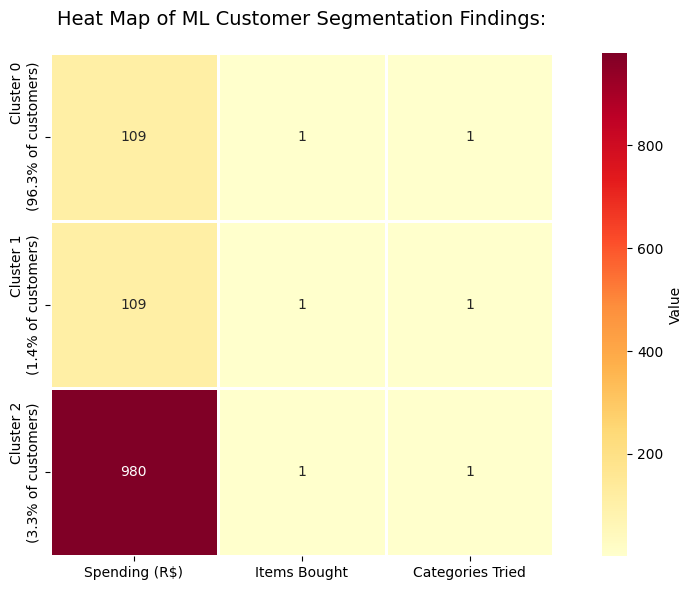


Insights from the Heat Map:

- Cluster 0: Typical customers - R$109 average spend
- Cluster 1:Pretty much similar to Cluster 0, but fewer categories
- Cluster 2: High spenders - R$980 average (9x more than others)

- Important Finding: All the groups basically focus on 1 product + 1 category.

- As shown by the heatmap, we can see the K-Mean Clustering is pretty
  much inneffective at segmenting customers into different groups as it just
  focuses on the spending and not customer behaviour, such as different
  products/categories.
  For this data it would be more effective avoiding the use of K-Means as shown.


In [50]:
print("\nHeat Map showing K-Means Clustering is generally focused just on the spendings:")

plt.figure(figsize=(10, 6))

# Create the heatmap data manually based on your insights
heatmap_data = [
    [109, 1, 1],  # Cluster 0: R$109 spend, 1 item, 1 category
    [109, 1, 1],  # Cluster 1: Similar to Cluster 0 (adjust values if different)
    [980, 1, 1]   # Cluster 2: R$980 spend, 1 item, 1 category
]

# Create DataFrame with clear labels
heatmap_df = pd.DataFrame(
    heatmap_data,
    index=['Cluster 0\n(96.3% of customers)', 
           'Cluster 1\n(1.4% of customers)', 
           'Cluster 2\n(3.3% of customers)'],
    columns=['Spending (R$)', 'Items Bought', 'Categories Tried']
)

# Create the heatmap
sns.heatmap(heatmap_df, annot=True, fmt='.0f', cmap='YlOrRd', # yellow orange green
            cbar_kws={'label': 'Value'}, square=True, linewidths=1)
plt.title('Heat Map of ML Customer Segmentation Findings:', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

print("\nInsights from the Heat Map:\n")

print("- Cluster 0: Typical customers - R$109 average spend")
print("- Cluster 1:Pretty much similar to Cluster 0, but fewer categories")
print("- Cluster 2: High spenders - R$980 average (9x more than others)\n")
print("- Important Finding: All the groups basically focus on 1 product + 1 category.\n")

print("- As shown by the heatmap, we can see the K-Mean Clustering is pretty\n" +
     "  much inneffective at segmenting customers into different groups as it just\n" +
     "  focuses on the spending and not customer behaviour, such as different\n" +
      "  products/categories.\n" + 
      "  For this data it would be more effective avoiding the use of K-Means as shown."
     )

### Step 5: Visualize the groups without ml

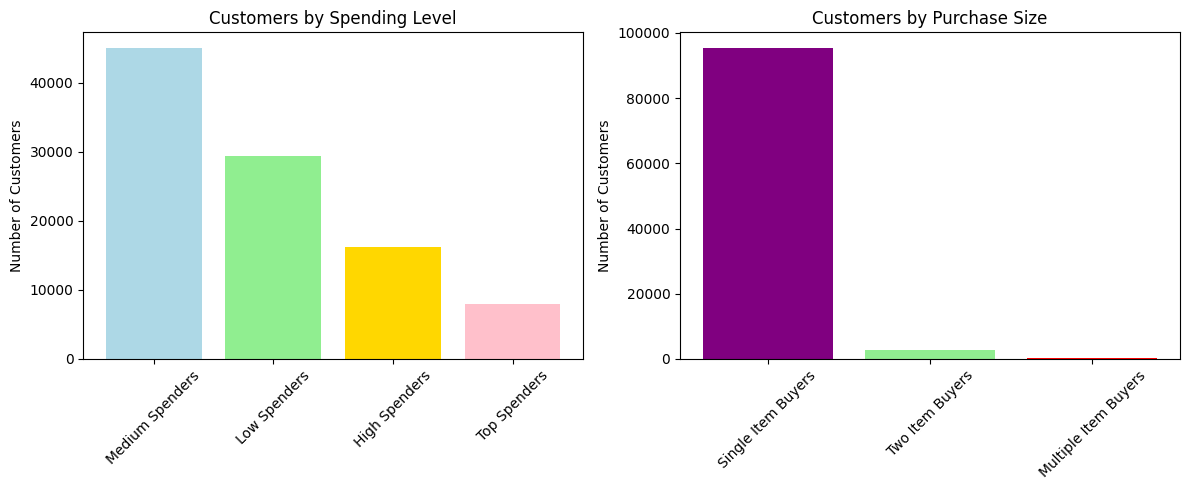

In [51]:
# comparison with two charts -> 2 bar graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left Chart: Spending groups
spending_counts = customer_stats['spending_group'].value_counts()
ax1.bar(spending_counts.index, spending_counts.values, color=['lightblue', 'lightgreen', 'gold', 'pink'])
ax1.set_title('Customers by Spending Level')
ax1.set_ylabel('Number of Customers')
ax1.tick_params(axis='x', rotation=45)

# Right Chart: Purchase size groups  
size_counts = customer_stats['purchase_size'].value_counts()
ax2.bar(size_counts.index, size_counts.values, color=['purple', 'lightgreen', 'red'])
ax2.set_title('Customers by Purchase Size')
ax2.set_ylabel('Number of Customers')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout() # make it tighter
plt.show() # show the charts

### Analyzing multi-item purchases

In [52]:
print("\nAnalyzing Single & Multi-Item Purchases:\n")


multi_item_customers = customer_stats[customer_stats['items_bought'] > 1]
single_item_customers = customer_stats[customer_stats['items_bought'] == 1]

# Total customer per group (single vs multi)
print(f"Single item customers: {len(single_item_customers)}")
print(f"Multi-item customers: {len(multi_item_customers)}")

# averag spent per group
print(f"\nSingle item customers spend: R$ {single_item_customers['total_spent'].mean():.2f}")
print(f"Multi-item customers spend: R$ {multi_item_customers['total_spent'].mean():.2f}")

# num of categories shown to have bought
print(f"\nSingle item categories explored: {single_item_customers['categories_tried'].mean():.1f}")
print(f"Multi-item categories explored: {multi_item_customers['categories_tried'].mean():.1f}\n") #only 1.2 categories -> average


Analyzing Single & Multi-Item Purchases:

Single item customers: 95430
Multi-item customers: 3236

Single item customers spend: R$ 135.65
Multi-item customers spend: R$ 199.84

Single item categories explored: 1.0
Multi-item categories explored: 1.2



# Conclusion